In [1]:
#%% Import Moduels

## System Tools
import os
import numpy as np
from collections import OrderedDict
import itertools
## I/O Tools
import pickle as pickle
## Data Process Tools
import pandas as pd
# import modin.pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
# import Graphics as MyGR
## Statistical Tools
from scipy.stats import t as TDist
import statsmodels.formula.api as sm
from statsmodels.tsa.api import VAR
from scipy.stats import mstats
import statsmodels.api as SMAPI
from statsmodels.tsa.tsatools import detrend as DeTrend
from statsmodels.tsa.filters.hp_filter import hpfilter as HPfilter
from statsmodels.tsa.filters.bk_filter import bkfilter as BKfilter
## Database API
# from fredapi import Fred
# fred = Fred(api_key='86cde3dec5dda5ffca44b58f01838b1e')
## Numerical API
from scipy.interpolate import interp1d
## Regular Expression API
import re
# import ray

idx = pd.IndexSlice
# End of Section: Import Moduels
###############################################################################

#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox (Bank of Canada)\\Research Projects\\02_EquityMarkets_MonetaryPolicy\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = 'TableGraph/SumStat/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################


# Load in the individual data sets

## SDC information

In [2]:
### Paths
DataFolder      =   "..\\temp\\"


### Read-in Data Sets

## Key Deal-level Information
DS_IssuanceInfo =   pickle.load(open(DataFolder+"SDC_IssuanceInfo.p","rb"))

## Response Variables: Daily/Accumulated Abnormal/Original Returns
DS_AbRet        =   pickle.load(open(DataFolder+"SDC_AbRet_Wide.p","rb"))
DS_Ret          =   pickle.load(open(DataFolder+"SDC_Ret_Wide.p","rb"))

## Shock Variables: Different Measure of Exposure to Monetary Shocks
DS_Ms           =   pickle.load(open(DataFolder+"SDC_UniqueEventDate2Ms.p","rb"))
DS_Ms           =   DS_Ms.reset_index().rename(columns={'index': 'EventDate'})

## Control 1: Aggregate Economic Conditions
DS_AggControl   =   pickle.load(open(DataFolder+"AggControl_Q.p","rb"))

### Control 2: Individual Stock Price Movement
#DS_RetHist      =   pickle.load(open(DataFolder+"SDC_Ret.p","rb"))
#DS_AbRet        =   pickle.load(open(DataFolder+"SDC_AbRet_Long.p","rb"))

## Control 3: Firm-Level Information
DS_FirmInfo     =   pickle.load(open(DataFolder+"SDC_CompustatQ_FirmInfo.p","rb"))
DS_CompustatQ   =   pickle.load(open(DataFolder+"SDC_CompustatQ.p","rb"))


<Axes: >

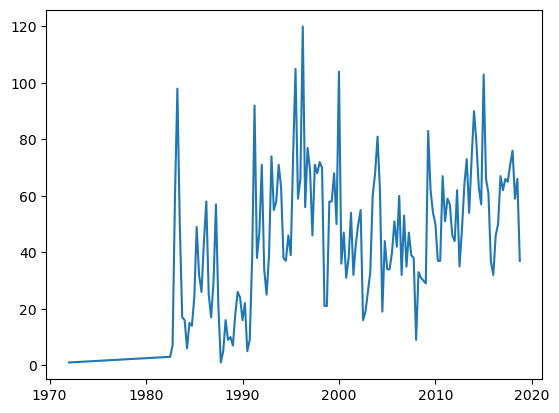

In [3]:
DS_IssuanceInfo['FilingDate_Quarter'].value_counts().sort_index().plot()

In [4]:
DS_FirmInfo

,IssueID,gvkey,sic,naics,year1,year2,ipodate,FF10_Code,FF10_Name,FF5_Code,FF5_Name
0,252165__19700114_19700114,003911,2834.0,3254,1966.0,1999.0,NaT,8.0,Hlth,4.0,Hlth
54,307000__19700120_19700120,004560,5331.0,452990,1970.0,2014.0,1987-01-01,7.0,Shops,1.0,Cnsmr
162,339099__19700120_19700120,004768,3716.0,336213,1964.0,2007.0,NaT,2.0,Durbl,1.0,Cnsmr
246,035285__19700122_19700122,001665,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
247,048825__19700202_19700202,001848,2911.0,324110,1950.0,1999.0,NaT,4.0,Enrgy,2.0,Manuf
...,...,...,...,...,...,...,...,...,...,...,...
412602,56854Q_10_20181211_20181212,020567,2836.0,325414,2012.0,2018.0,2014-07-31,8.0,Hlth,4.0,Hlth
412627,91822J_10_20181212_20181213,025289,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
412628,68401U_20_20181217_20181218,023464,7370.0,519130,2013.0,2019.0,NaT,5.0,HiTec,3.0,HiTec
412656,30234E_10_20181212_20181219,032861,2836.0,325414,2015.0,2019.0,2018-01-25,8.0,Hlth,4.0,Hlth


In [5]:
DS_IssuanceInfo.shape 

(7930, 71)

## Compustat 

In [6]:
DS_CS = pickle.load(open("../datasets/Compustat/Sample_CS_Q_Cleaned.p", "rb"))

In [7]:
DS_CS['IpoYear'] = DS_CS['ipodate'].dt.year

DS_CS['InvRate'] = DS_CS['CapExp']/DS_CS['Lag_Asset']*4*100
DS_CS['EquIssRate'] = DS_CS['EquityIssuance']/DS_CS['Lag_Asset']*400
DS_CS['Payout'] = DS_CS['Dividend']+DS_CS['StockRepurchase']
DS_CS['PayoutRate'] = DS_CS['Payout']/DS_CS['Lag_Asset']*400
DS_CS['OptCashFlowRate'] = DS_CS['OptCashFlow']/DS_CS['Lag_Asset']*4*100

# Construct the data set of issuance linked to firm id

In [8]:
DS = DS_IssuanceInfo.merge(DS_FirmInfo[['IssueID', 'gvkey']], on='IssueID', how='outer', indicator=True)
DS['_merge'].value_counts()

both          7313
left_only      617
right_only       0
Name: _merge, dtype: int64

In [40]:
AbRetVar = ['F_AccUniAbRet_-1_1', 'I_AccUniAbRet_-1_1']
DS = DS.merge(DS_AbRet[['IssueID'] + AbRetVar], on='IssueID', how='left')

In [18]:
DS.columns

Index(['IssueID', 'IssueID_ObsNum', 'FilingDate', 'FilingDateFlag',
       'FilingDate_Year', 'FilingDate_Quarter', 'FilingDate_Month',
       'LaunchDate', 'LaunchDateFlag', 'LaunchDate_Year', 'LaunchDate_Quarter',
       'LaunchDate_Month', 'IssueDate', 'IssueDateFlag', 'IssueDate_Year',
       'IssueDate_Quarter', 'IssueDate_Month', 'GapDays_F2I', 'GapDays_L2I',
       'GapDays_F2L', 'GapBusDays_F2I', 'GapBusDays_L2I', 'GapBusDays_F2L',
       'SIC', 'FF5_Name', 'FF5_Code', 'FF10_Name', 'FF10_Code', 'Issuer',
       'Nation', 'Exchange', 'CUSIP', 'CUSIP_9digit', 'CUSIP_1_6', 'CUSIP_7_8',
       'CUSIP_8digit', 'CUSIP_DigitNum', 'TickerSymbol', 'DaysInRegistration',
       'RightsOfferFlag', 'Rule415ShelfFlag', 'ProceedsUse', 'PrincipalAmount',
       'FiledAmount', 'ProceedsAmount', 'RealPrincipalAmount',
       'RealFiledAmount', 'RealProceedsAmount', 'FiledShares',
       'OfferedTotalShares', 'OfferedPrimaryShares', 'OfferedSecondaryShares',
       'OfferAvgPrice', 'OfferedPrimar

<Axes: title={'center': 'CDF of the gap days btw filing and issuance'}, xlabel='GapBusDays_F2I'>

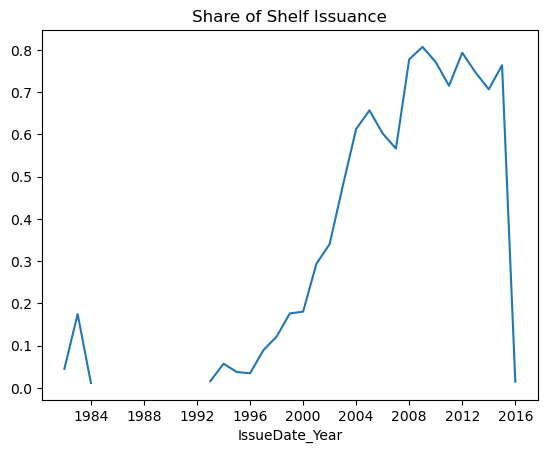

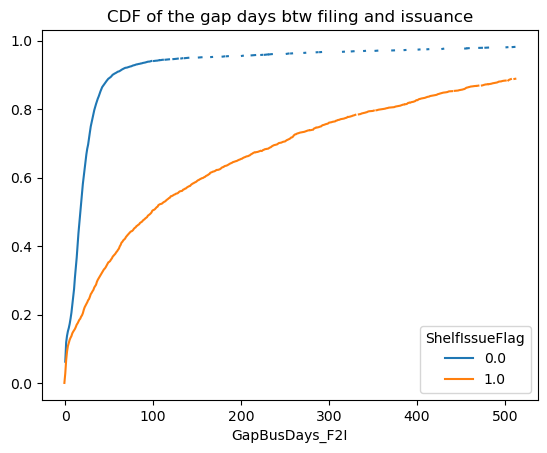

In [38]:
DS.groupby('IssueDate_Year')['ShelfIssueFlag'].value_counts(normalize=True).unstack()[1].plot(title="Share of Shelf Issuance")
DS.groupby('ShelfIssueFlag')['GapBusDays_F2I'].value_counts(normalize=True).unstack(level=0).sort_index().cumsum().loc[:256*2].plot(title="CDF of the gap days btw filing and issuance")

<Axes: xlabel='IssueDate_Year'>

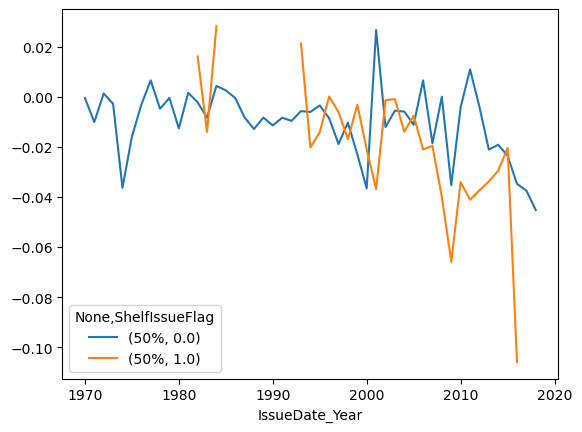

In [48]:
DS.groupby(['IssueDate_Year', 'ShelfIssueFlag'])['I_AccUniAbRet_-1_1'].describe().unstack(level='ShelfIssueFlag').sort_index(axis=1).loc[:, [ '50%']].plot()

<Axes: xlabel='FilingDate_Year'>

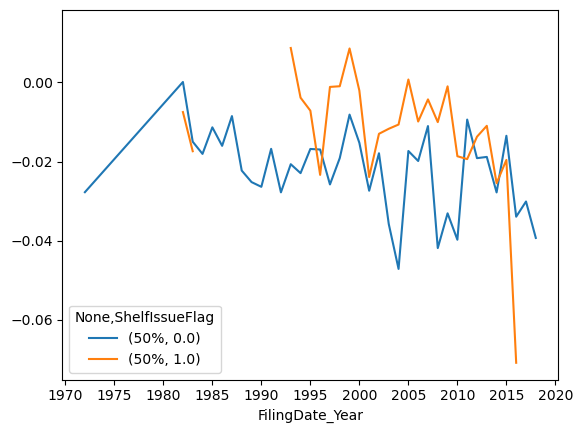

In [50]:
DS.groupby(['FilingDate_Year', 'ShelfIssueFlag'])['F_AccUniAbRet_-1_1'].describe().unstack(level='ShelfIssueFlag').sort_index(axis=1).loc[:, [ '50%']].plot()

(-1.0, 1.0)

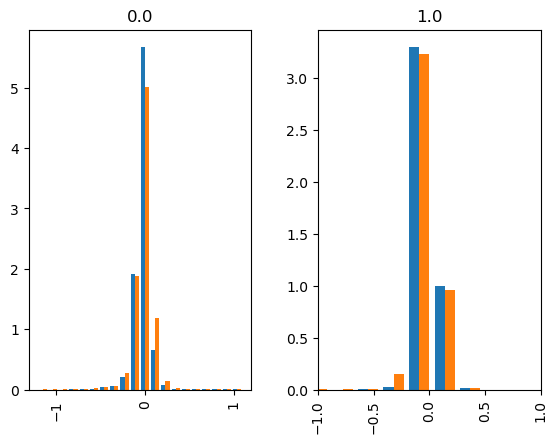

In [62]:
DS.hist(['F_AccUniAbRet_-1_1', 'I_AccUniAbRet_-1_1'], by='ShelfIssueFlag', bins=20, density=True)
plt.xlim(-1, 1)

In [61]:
plt.hist?

Signature:
plt.hist(
    x,
    bins=None,
    range=None,
    density=False,
    weights=None,
    cumulative=False,
    bottom=None,
    histtype='bar',
    align='mid',
    orientation='vertical',
    rwidth=None,
    log=False,
    color=None,
    label=None,
    stacked=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in each bin, then draws the distribution either as a
`.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
*weights* parameters are forwarded to `numpy.histogram`.

If the data has already been binned and counted, use `~.bar` or
`~.stairs` to plot the distribution::

    counts, bins = np.histogram(x)
    plt.stairs(counts, bins)

Alternatively, plot pre-computed bins and counts using ``hist()`` by
treating each bin as a single point with a weight equal to its count::

    plt.hist(bins[:-1], bins, weights=counts)

The data input

<Axes: xlabel='GapBusDays_L2I'>

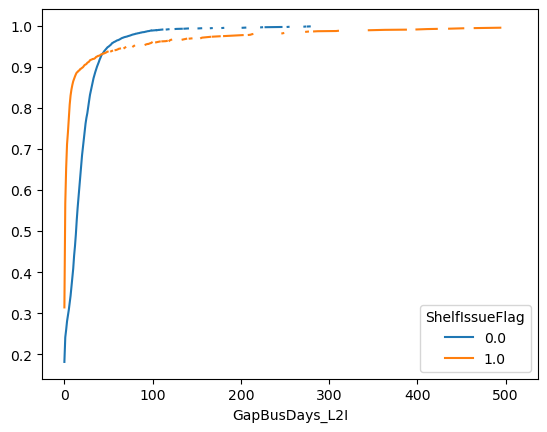

In [32]:
DS.groupby('ShelfIssueFlag')['GapBusDays_L2I'].value_counts(normalize=True).unstack(level=0).sort_index().cumsum().loc[:256*2].plot()


In [17]:
temp.loc[:, temp.columns > 30].sum(axis=1)


IssueDate_Year
1972-01-01    0.000000
1982-01-01    0.000000
1983-01-01    0.200873
1984-01-01    0.169811
1985-01-01    0.134921
1986-01-01    0.174497
1987-01-01    0.117117
1988-01-01    0.054054
1989-01-01    0.202703
1990-01-01    0.083333
1991-01-01    0.242857
1992-01-01    0.309091
1993-01-01    0.268000
1994-01-01    0.298969
1995-01-01    0.215094
1996-01-01    0.291139
1997-01-01    0.281250
1998-01-01    0.327684
1999-01-01    0.342466
2000-01-01    0.288372
2001-01-01    0.439716
2002-01-01    0.463235
2003-01-01    0.589286
2004-01-01    0.680556
2005-01-01    0.604651
2006-01-01    0.563218
2007-01-01    0.526946
2008-01-01    0.569444
2009-01-01    0.669643
2010-01-01    0.682051
2011-01-01    0.575000
2012-01-01    0.640884
2013-01-01    0.626667
2014-01-01    0.496000
2015-01-01    0.554795
2016-01-01    0.435424
2017-01-01    0.199357
2018-01-01    0.122677
dtype: float64